<a href="https://colab.research.google.com/github/Shohei496/Deep-met/blob/circleci-project-setup/Step3%E3%83%87%E3%82%A3%E3%83%BC%E3%83%97%E3%83%A1%E3%83%88%E3%83%AA%E3%83%83%E3%82%AF%E3%83%A9%E3%83%BC%E3%83%8B%E3%83%B3%E3%82%B0%E3%80%90%E3%83%86%E3%82%B9%E3%82%BF%E3%83%BC%E3%80%91_ipynb_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#0
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#1

import os
import random
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import model_selection
from sklearn import preprocessing
import IPython.display as ipd

In [ ]:
#2

# define directories

base_dir = "drive/MyDrive/"
esc_dir = os.path.join(base_dir, "data")
audio_dir = os.path.join(esc_dir, "audio/Filter/")
meta_file = os.path.join(esc_dir, "meta/meta_data_test.csv")#テストメタデータ
#meta_file2 = os.path.join(esc_dir, "meta/meta_data.csv")#

In [ ]:
#3

# load metadata
meta_data = pd.read_csv(meta_file, encoding="shift-jis")
meta_data

,filename,target
0,a2noise.wav のコピー,1
1,a3noise.wav のコピー,1
2,a4noise.wav のコピー,1
3,a5noise.wav のコピー,1
4,a6noise.wav のコピー,1
5,a7noise.wav のコピー,1
6,a8noise.wav のコピー,1
7,a9noise.wav のコピー,1
8,a10noise.wav のコピー,1


In [ ]:
#4

# get data size
data_size = meta_data.shape
print(data_size)

(9, 2)


In [ ]:
#5

# load a wave data
def load_wave_data(audio_dir, file_name):
    file_path = os.path.join(audio_dir, file_name)
    x, fs = librosa.load(file_path, sr=44100)
    x = x[0:160000]
    max_data = np.max(x)
    min_data = np.min(x)
    x = (x-min_data)/(max_data-min_data)
   # x = (x-min_data)/(max_data-min_data+1e-6)
   # return _x-0.5
    return x,fs

In [ ]:
#6

# change wave data to mel-stft
def calculate_melsp(x, n_fft=1024, hop_length=128):
    
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    log_stft = librosa.power_to_db(stft)
    melsp = log_stft

    #melsp = librosa.feature.melspectrogram(S=log_stft,n_mels=128)


    return melsp

In [ ]:
#7

# display wave in plots
def show_wave(x):
    plt.plot(x)
    #plt.figure(figsize=(5,4))

    plt.show()

In [ ]:
#8

# display wave in heatmap
def show_melsp(melsp, fs):
    #librosa.display.specshow(melsp, sr=fs)
    plt.figure(figsize=(20,4))
    plt.imshow(melsp)
    #plt.imshow(melsp, interpolation='nearest',vmin=-50,vmax=-30,cmap='jet')
    plt.colorbar()
    plt.show()

In [ ]:
#9

# get training dataset and target dataset
x = list(meta_data.loc[:,"filename"])
y = list(meta_data.loc[:, "target"])
x_test=x
y_test=y

                                                        

In [ ]:
#10

freq = 513
time = 1251

In [ ]:
#11

# save wave data in npz, with augmentation
def save_np_data(filename, x, y,aug=None, rates=None):
    name = np.zeros(len(x),dtype=str)
    np_data = np.zeros(freq*time*len(x)).reshape(len(x), freq, time)
    np_targets = np.zeros(len(y))
    
    for i in range(len(y)):
        _x, fs = load_wave_data(audio_dir, x[i])
        if aug is not None:
            _x = aug(x=_x, rate=rates[i])
        _x = calculate_melsp(_x)
       # _x = show_melsp(_x, fs)
        np_data[i] = _x
        
        np_targets[i] = y[i]

        name[i] = x[i] 
        
        
    np.savez(filename, x=np_data, y=np_targets, z=name)  

In [ ]:
#12

# save test dataset
if not os.path.exists("esc_melsp_test.npz"):
    save_np_data("esc_melsp_test.npz", x_test,  y_test)
    #np.savez("esc_melsp_test.npz",x=x_test,y=y_test)


In [ ]:
#13

!pip install pytorch-metric-learning
!pip install faiss-gpu

     |████████████████████████████████| 107 kB 6.8 MB/s 
     |████████████████████████████████| 85.5 MB 142 kB/s 


In [ ]:
#14

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from pytorch_metric_learning.utils import common_functions


In [ ]:
#15

freq = 513
time = 1251
test_num = len(x_test)
#test_num = 7


In [ ]:
#16

test_file =  "esc_melsp_test.npz"
#plus_file =  "esc_melsp_plus.npz"





In [ ]:
#17

test_data = np.load(test_file)


test_data_x = torch.from_numpy(test_data["x"]).float()
test_data_y = torch.from_numpy(test_data["y"]).long()
#test_name = torch.from_numpy(test_data["z"]).float()



In [ ]:
#18

mean = torch.mean(test_data_x, axis=0)
std = torch.std(test_data_x, axis=0)

test_data_x = (test_data_x - mean)/std
test_data_x = test_data_x.unsqueeze(1)

In [ ]:
#19

test_datas = torch.utils.data.TensorDataset(test_data_x, test_data_y)
test_loader = DataLoader(test_datas ,batch_size=1, shuffle=True)



In [ ]:
#20

#####オリジナルモデルVer
from torchvision import models
model=models.resnet50()
resnet_model=model
#resnet_model.fc = nn.Linear(2048, 8)
resnet_model.fc = common_functions.Identity()
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

#resnet_model_output_size = model.fc.in_features

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model = torch.nn.DataParallel(resnet_model.to(device))
resnet_model.load_state_dict(torch.load('drive/MyDrive/data/model/models.pth'))
#resnet_model_output_size = model.fc.in_features

<All keys matched successfully>

In [ ]:
#21

### データ評価 ###

device = torch.device("cuda")

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)



plus_loader = test_loader
model = resnet_model
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 1

## pytorch-metric-learning stuff ###
distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low=0)
loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
mining_func = miners.TripletMarginMiner(
    margin=0.2, distance=distance, type_of_triplets="semihard"
)
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=1)
### pytorch-metric-learning stuff ###


In [ ]:
#22

####テスト実行#####

#plus_predicted_metrics = []
#plus_true_labels = []
test_predicted_metrics = []
test_true_labels = []

def loss_plus(model, plus_loader):
 with torch.no_grad():
        model.eval()
        for i, (inputs,  labels) in enumerate(plus_loader):
           # inputs, labels = inputs.to(device), labels.to(device)
           # inputs = inputs.unsqueeze(1)
            metric = model(inputs).detach().cpu().numpy()
            metric = metric.reshape(metric.shape[0], metric.shape[1])
            test_predicted_metrics.append(metric)
            test_true_labels.append(labels.detach().cpu().numpy())
           # if labels<1:
           #    plus_predicted_metrics.append(metric)
           #    plus_true_labels.append(labels.detach().cpu().numpy())
           # else:
           #    test_predicted_metrics.append(metric)
           #    test_true_labels.append(labels.detach().cpu().numpy())
 #return np.concatenate(plus_predicted_metrics), np.concatenate(plus_true_labels),np.concatenate(test_predicted_metrics), np.concatenate(test_true_labels)

        return np.concatenate(test_predicted_metrics), np.concatenate(test_true_labels)
#plus_predicted_metrics,plus_true_labels,test_predicted_metrics,test_true_labels=loss_plus(model, plus_loader)
test_predicted_metrics,test_true_labels=loss_plus(model, plus_loader)

In [ ]:
#23

####正常データロード
metrics2 = np.load('drive/MyDrive/data/met/met.npy')
lab2 =  np.load('drive/MyDrive/data/met/lab.npy')


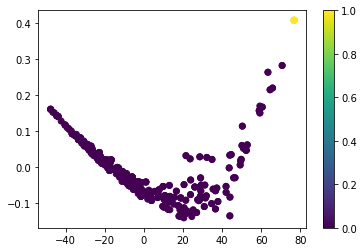

In [ ]:
#24

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA 
#主成分分析器
metrics = np.vstack((metrics2,test_predicted_metrics))
metrics_labels = np.hstack((lab2,test_true_labels))



pca_metrics = PCA(n_components=2, random_state=0).fit_transform(metrics)
plt.scatter(pca_metrics[:, 0], pca_metrics[:, 1], c=metrics_labels)
#plt.scatter(pca_metrics[:, 0], pca_metrics[:, 1], c=plus_true_labels[-1])
plt.colorbar()
plt.savefig("notrainBC.png")
plt.show()

In [ ]:
#25

####テストデータ　コサイン類似度計算

from sklearn.metrics.pairwise import cosine_similarity

sim1 = cosine_similarity(test_predicted_metrics,metrics2)
sim1 = np.max(sim1, axis=-1)

In [ ]:
#26

###閾値計算

SIGMA = 2
simsok = cosine_similarity(metrics2, metrics2)
#simsok =  np.mean(simsok, axis=-1)
m = np.mean(simsok, axis=-1)
m = np.max(m)
std = np.std(simsok, axis=-1)
std = np.max(std)
h = std*SIGMA
dist_min, dist_max = m-h, m+h  # 各次元の正常範囲

print(dist_min)
dist = []
dist.append(dist_min)
#print(dist_max)

0.999637777073076


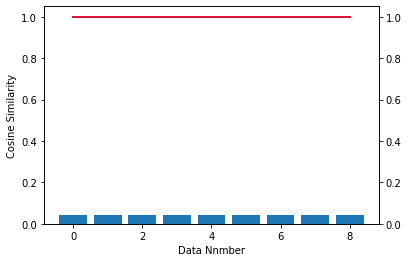

In [ ]:
#27

####グラフ描写

import matplotlib.pyplot as plt

x = range(len(sim1))
height = sim1
line_height = np.array([dist_min]*len(sim1)) 

fig, ax1 = plt.subplots()   

ax1.bar(x, height)
ax1.set_xlabel('Data Nnmber')
ax1.set_ylabel('Cosine Similarity')
plt.ylim(0, 1.05)

ax2 = ax1.twinx()
ax2.plot(x, line_height, linewidth=2, color="crimson")
plt.ylim(0, 1.05)

plt.show()